In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
# from w207_util import *


2022-07-10 22:09:05.816815: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3446)


In [4]:

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)

print(init_df.head())

features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

init_df.head()
print(init_df.columns)


y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)

X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_validate = np.array(X_validate).reshape((X_validate.shape[0],X_test.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)



   lag1_mean_0  lag1_mean_1  lag1_mean_2  lag1_mean_3  lag1_mean_4  \
0     0.165685    -0.852441     0.305529     0.069311    -0.820157   
1    -1.280358    -3.529726     1.199699    -1.149790     0.738967   
2     1.830922    -1.242559     0.019590    -0.955141     4.069830   
3     0.726474    -0.013534     3.577241    -1.806816     0.604612   
4    -0.338823     0.202537    -0.062122    -1.623981    -0.346947   

   lag1_mean_5  lag1_mean_6  lag1_mean_7  lag1_mean_8  lag1_mean_9  ...  \
0     0.671192    -0.889876     0.491933    -0.284130     0.031775  ...   
1    -4.185435    -1.864589    -0.710929     2.279327     0.201870  ...   
2    -8.934466     0.863457     1.437240    -1.496749     0.993456  ...   
3    -0.489957     0.936905    -2.145070    -0.171676    -0.505224  ...   
4    -0.717592    -1.123954    -1.435684     0.115600    -1.780939  ...   

   freq_669_12  freq_679_12  freq_689_12  freq_699_12  freq_709_12  \
0     0.010112     0.002127     0.010123     0.004699     

In [5]:
def train_model(x_train, y_train,x_validate, y_validate,
                save_to, epoch = 2):
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    with strategy.scope():   
        model = Sequential()
        
        model.add(LSTM(256, return_sequences=True))
        
        model.add(tf.keras.layers.Conv1D(
            filters=32,                
            kernel_size=3,
            strides=1,
            padding='same',
            data_format='channels_last',
            name='conv_1',
            activation='relu'))
        
        model.add(tf.keras.layers.MaxPool1D(
            pool_size=2,
            name='pool_1'))
        
        # add second convolutional layer
        model.add(tf.keras.layers.Conv1D(
            filters=64,
            kernel_size=3,
            strides=1,
            padding='same',
            name='conv_2',
            activation='relu'))

        model.add(tf.keras.layers.MaxPool1D(
            pool_size=2, 
            name='pool_2')
        )
        
        model.add(Flatten()) 
        
        # Add Dense layer
        model.add(tf.keras.layers.Dense(
            units=1024,
            name='fc_1', 
            activation='relu'))

        # add dropout layer
        model.add(tf.keras.layers.Dropout(
            rate=0.5))
        
#         model.add(tf.keras.layers.Dense(
#         units=512,
#         name='fc_2', 
#         activation='relu'))

#         # add dropout layer
#         model.add(tf.keras.layers.Dropout(
#             rate=0.5))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, X_train.shape[1], 1))
        model.summary()
        tf.keras.utils.plot_model(model)

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model_lstm_all_cat.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
            
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
            
        model.compile(optimizer=opt_adam,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy'])
        
    history = model.fit(x_train,y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_validate, y_validate),
                        callbacks=[es,mc,lr_schedule])
        
    saved_model = load_model(save_to + '_best_model_lstm_all_cat.h5')
        
    return model,history


In [7]:

model,history = train_model(X_train, y_train, X_validate, y_validate, save_to= './', epoch = 40)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2022-07-10 22:11:10.085249: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-10 22:11:10.087546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:67:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-07-10 22:11:10.089671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:68:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-07-10 22:11:10.089822: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-10 22:11:10.089898: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
20

Number of devices: 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3445, 256)         264192    
_________________________________________________________________
conv_1 (Conv1D)              (None, 3445, 32)          24608     
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1722, 64)          6208      
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 861, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 55104)             0         
_________________________________________________________________
fc_1 (Dense)                 (None,

2022-07-10 22:11:11.970052: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_805"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto

Epoch 1/40
INFO:tensorflow:batch_all_reduce: 11 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 11 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/t

2022-07-10 22:11:16.358961: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-10 22:11:16.758638: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


752/752 [==============================] - ETA: 0s - loss: 1.3741 - accuracy: 0.3945

2022-07-10 22:13:14.485070: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8346"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.aut

752/752 [==============================] - 138s 175ms/step - loss: 1.3738 - accuracy: 0.3946 - val_loss: 0.8303 - val_accuracy: 0.6477

Epoch 00001: val_accuracy improved from -inf to 0.64774, saving model to ./_best_model_lstm_all_cat.h5
Epoch 2/40
752/752 [==============================] - 130s 173ms/step - loss: 0.7931 - accuracy: 0.6689 - val_loss: 0.6793 - val_accuracy: 0.7230

Epoch 00002: val_accuracy improved from 0.64774 to 0.72298, saving model to ./_best_model_lstm_all_cat.h5
Epoch 3/40
752/752 [==============================] - 130s 172ms/step - loss: 0.5188 - accuracy: 0.7964 - val_loss: 0.5965 - val_accuracy: 0.7702

Epoch 00003: val_accuracy improved from 0.72298 to 0.77015, saving model to ./_best_model_lstm_all_cat.h5
Epoch 4/40
752/752 [==============================] - 130s 173ms/step - loss: 0.3381 - accuracy: 0.8721 - val_loss: 0.5402 - val_accuracy: 0.7914

Epoch 00004: val_accuracy improved from 0.77015 to 0.79137, saving model to ./_best_model_lstm_all_cat.h5
Ep

In [8]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

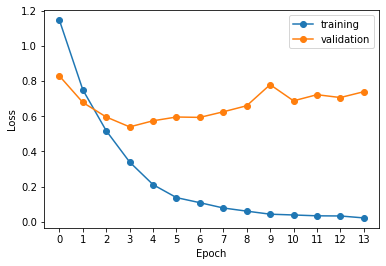

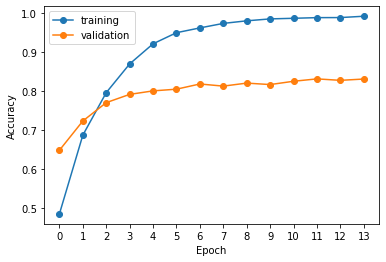

In [10]:
# don't plot, big image data to commit to git.
history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

In [9]:
# test model
test_results = model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

  1/251 [..............................] - ETA: 35s - loss: 0.6500 - accuracy: 0.7812

2022-07-10 22:46:17.118388: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_40674"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.au

251/251 [==============================] - 15s 59ms/step - loss: 0.7108 - accuracy: 0.8341

Test Acc. 83.41%


In [ ]:
# train/validate/test
#1 LSTM -> 2 Conv1D(32/64) -> 2 Dense (1024/512): 
#  loss: 0.0225 - accuracy: 0.9913 - val_loss: 0.7405 - val_accuracy: 0.8308 - val_accuracy: 0.8299
#  test accuracy: 83.41%

